In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output

## Process location of taxi zone

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 14.5+ KB
['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']


<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

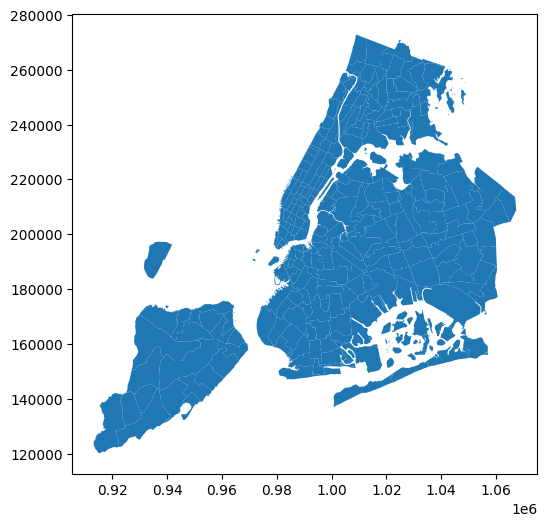

In [2]:
import geopandas as gpd
taxi_zones = gpd.read_file(r'/home/hungnq/hungnq_2/taxi_EDA/taxi_zone/taxi_zones.shp')
taxi_zones.info()
taxi_zones.plot(figsize=(6,6))
print(taxi_zones.columns.to_list())
taxi_zones.crs

In [20]:
taxi_zones = taxi_zones.to_crs(epsg=4326) # project the centroids' locations to another coordinate system
taxi_zones['centroid'] = taxi_zones['centroid'].to_crs(epsg=4326)
taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroid,c_latitude,c_longitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",POINT (-74.17400 40.69183),191376.749531,9.359968e+05
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675),164018.754403,1.031086e+06
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.84742 40.86447),254265.478659,1.026453e+06
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",POINT (-73.97697 40.72375),202959.782391,9.906340e+05
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",POINT (-74.18848 40.55266),140681.351376,9.318714e+05


In [21]:
taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroid,c_latitude,c_longitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",POINT (-74.17400 40.69183),191376.749531,9.359968e+05
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675),164018.754403,1.031086e+06
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.84742 40.86447),254265.478659,1.026453e+06
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",POINT (-73.97697 40.72375),202959.782391,9.906340e+05
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",POINT (-74.18848 40.55266),140681.351376,9.318714e+05


In [22]:
import folium

m1 = folium.Map(location=[40.70, -73.94], zoom_start=12)

# add centroid marker to each taxi zones
latitudes = []
longitudes = []
# markers_group = folium.FeatureGroup(name='Taxi Zones Centroids')
for _, r in taxi_zones.iterrows():
    lat = r['centroid'].y
    latitudes.append(lat)
    lon = r['centroid'].x
    longitudes.append(lon)
    folium.Marker(location=[lat, lon], popup='LocationID:{}<br>Zone:{}<br>Borough:{}'.format(r['LocationID'], r['zone'], r['borough']),icon=folium.Icon(icon='info-sign')).add_to(m1)

# project geometries on the map to locate precise regions of taxi zones
for _, r in taxi_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.0001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(r['zone']).add_to(geo_j)
    geo_j.add_to(m1)
    
# markers_group.add_to(m)
taxi_zones['c_latitude'] = latitudes
taxi_zones['c_longitude'] = longitudes
# m1.save('maps/taxi_zones.html') # save as html
# m1

## Process distance and trip duration 

### Preprocess datetime and location

In [23]:
green_tripdata = pd.read_parquet('/home/hungnq/hungnq_2/taxi_EDA/green_tripdata_2023-06.parquet')
green_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65550 entries, 0 to 65549
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               65550 non-null  int32         
 1   lpep_pickup_datetime   65550 non-null  datetime64[us]
 2   lpep_dropoff_datetime  65550 non-null  datetime64[us]
 3   store_and_fwd_flag     60359 non-null  object        
 4   RatecodeID             60359 non-null  float64       
 5   PULocationID           65550 non-null  int32         
 6   DOLocationID           65550 non-null  int32         
 7   passenger_count        60359 non-null  float64       
 8   trip_distance          65550 non-null  float64       
 9   fare_amount            65550 non-null  float64       
 10  extra                  65550 non-null  float64       
 11  mta_tax                65550 non-null  float64       
 12  tip_amount             65550 non-null  float64       
 13  t

In [24]:
green_tripdata = green_tripdata.drop(columns=['ehail_fee'])
len(green_tripdata)

<class 'pandas.core.frame.DataFrame'>
Index: 60359 entries, 0 to 60358
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               60359 non-null  int32         
 1   lpep_pickup_datetime   60359 non-null  datetime64[us]
 2   lpep_dropoff_datetime  60359 non-null  datetime64[us]
 3   store_and_fwd_flag     60359 non-null  object        
 4   RatecodeID             60359 non-null  float64       
 5   PULocationID           60359 non-null  int32         
 6   DOLocationID           60359 non-null  int32         
 7   passenger_count        60359 non-null  float64       
 8   trip_distance          60359 non-null  float64       
 9   fare_amount            60359 non-null  float64       
 10  extra                  60359 non-null  float64       
 11  mta_tax                60359 non-null  float64       
 12  tip_amount             60359 non-null  float64       
 13  tolls_

In [25]:
green_tripdata = pd.merge(green_tripdata, taxi_zones, how='left',left_on='PULocationID',right_on='LocationID', suffixes=('_PU', '_DO')).drop(columns=['PULocationID'])
green_tripdata = pd.merge(green_tripdata, taxi_zones, how='left',left_on='DOLocationID',right_on='LocationID', suffixes=('_PU', '_DO')).drop(columns=['DOLocationID'])

In [26]:
green_tripdata = green_tripdata[(green_tripdata["LocationID_PU"] != 265) & (green_tripdata["LocationID_PU"] !=  264) &
                         (green_tripdata["LocationID_PU"] !=  265) & (green_tripdata["LocationID_PU"] !=  264)]
green_tripdata = green_tripdata.dropna()
green_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60758 entries, 0 to 60757
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               60758 non-null  int32         
 1   lpep_pickup_datetime   60758 non-null  datetime64[us]
 2   lpep_dropoff_datetime  60758 non-null  datetime64[us]
 3   store_and_fwd_flag     60758 non-null  object        
 4   RatecodeID             60758 non-null  float64       
 5   passenger_count        60758 non-null  float64       
 6   trip_distance          60758 non-null  float64       
 7   fare_amount            60758 non-null  float64       
 8   extra                  60758 non-null  float64       
 9   mta_tax                60758 non-null  float64       
 10  tip_amount             60758 non-null  float64       
 11  tolls_amount           60758 non-null  float64       
 12  improvement_surcharge  60758 non-null  float64       
 13  t

### get trip duration

In [27]:
green_tripdata['pickup_datetime'] = pd.to_datetime(green_tripdata['lpep_pickup_datetime'])
green_tripdata['dropoff_datetime'] = pd.to_datetime(green_tripdata['lpep_dropoff_datetime'])

In [28]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
green_tripdata['weekday'] = green_tripdata.pickup_datetime.dt.weekday
green_tripdata['month'] = green_tripdata.pickup_datetime.dt.month
green_tripdata['weekday_num'] = green_tripdata.pickup_datetime.dt.day_of_week
green_tripdata['pickup_hour'] = green_tripdata.pickup_datetime.dt.hour
green_tripdata['trip_duration'] = green_tripdata['dropoff_datetime'] - green_tripdata['pickup_datetime']
# call manually each `total_seconds()` for each sample in data
green_tripdata['trip_duration'] = [green_tripdata['trip_duration'][index].total_seconds() for index in green_tripdata['trip_duration'].index]

### get trip coordinate latitude and longtitude

In [34]:
green_tripdata['c_latitude_PU'].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       60748, 60749, 60750, 60751, 60752, 60753, 60754, 60755, 60756, 60757],
      dtype='int64', length=59873)

In [36]:
distance = []
for index in green_tripdata['c_latitude_PU'].index:
    clear_output()
    print(index)
    distance.append(geodesic((green_tripdata['c_latitude_PU'][index],green_tripdata['c_longitude_PU'][index]),
                             (green_tripdata['c_latitude_DO'][index],green_tripdata['c_longitude_DO'][index])).miles)
green_tripdata['distance'] = distance

60757


### get speed of each taxi

In [44]:
green_tripdata['speed'] = (green_tripdata.distance/(green_tripdata.trip_duration/3600))

## EDA on univariable

In [47]:
green_tripdata.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,c_longitude_DO,pickup_datetime,dropoff_datetime,weekday,month,weekday_num,pickup_hour,distance,trip_duration,speed
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,N,1.0,1.0,0.84,7.9,1.0,0.5,...,-73.940772,2023-06-01 00:32:25,2023-06-01 00:39:06,3,6,3,0,1.192745,401.0,10.707934
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,N,1.0,1.0,4.05,19.1,1.0,0.5,...,-73.965146,2023-06-01 00:39:07,2023-06-01 00:51:59,3,6,3,0,3.364301,772.0,15.688451
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,N,1.0,1.0,4.26,23.3,1.0,0.5,...,-73.960968,2023-06-01 00:35:59,2023-06-01 00:57:06,3,6,3,0,3.721799,1267.0,10.574963
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,N,1.0,1.0,1.79,12.1,1.0,0.5,...,-73.951010,2023-06-01 00:50:29,2023-06-01 01:00:32,3,6,3,0,0.823518,603.0,4.916528
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,N,1.0,1.0,6.40,37.3,1.0,0.5,...,-73.989845,2023-06-01 00:15:15,2023-06-01 00:52:40,3,6,3,0,4.594294,2245.0,7.367242


### vendor id

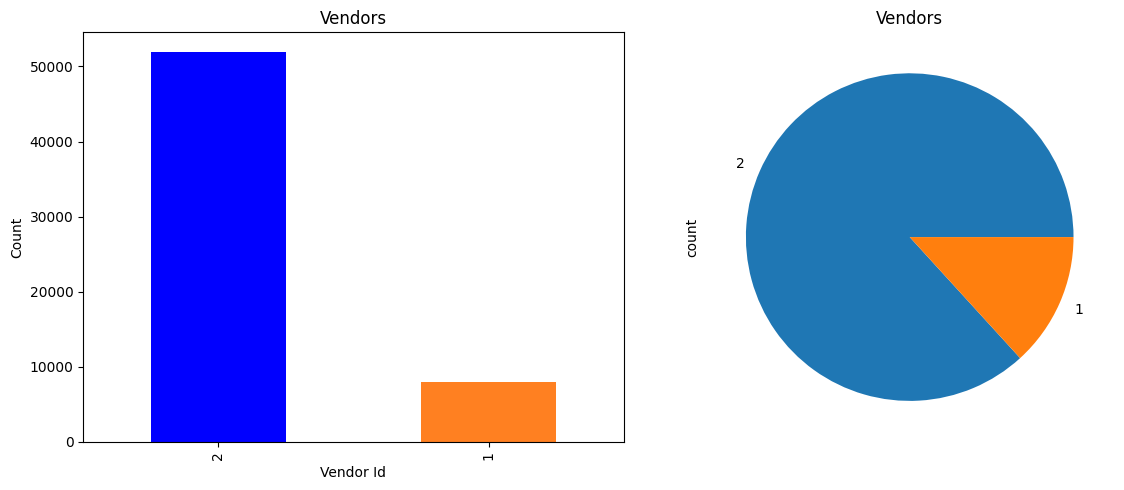

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = green_tripdata['VendorID'].value_counts().plot(kind='bar',title="Vendors",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))
green_tripdata['VendorID'].value_counts().plot(kind='pie',title="Vendors",ax=axes[1])
ax.set_ylabel("Count")
ax.set_xlabel("Vendor Id")
fig.tight_layout()

In [49]:
pd.options.display.float_format = '{:.2f}'.format #To suppress scientific notation.
green_tripdata.passenger_count.value_counts()

passenger_count
1.00    50910
2.00     5199
5.00     1535
3.00      802
6.00      686
0.00      417
4.00      314
7.00        4
8.00        4
9.00        2
Name: count, dtype: int64

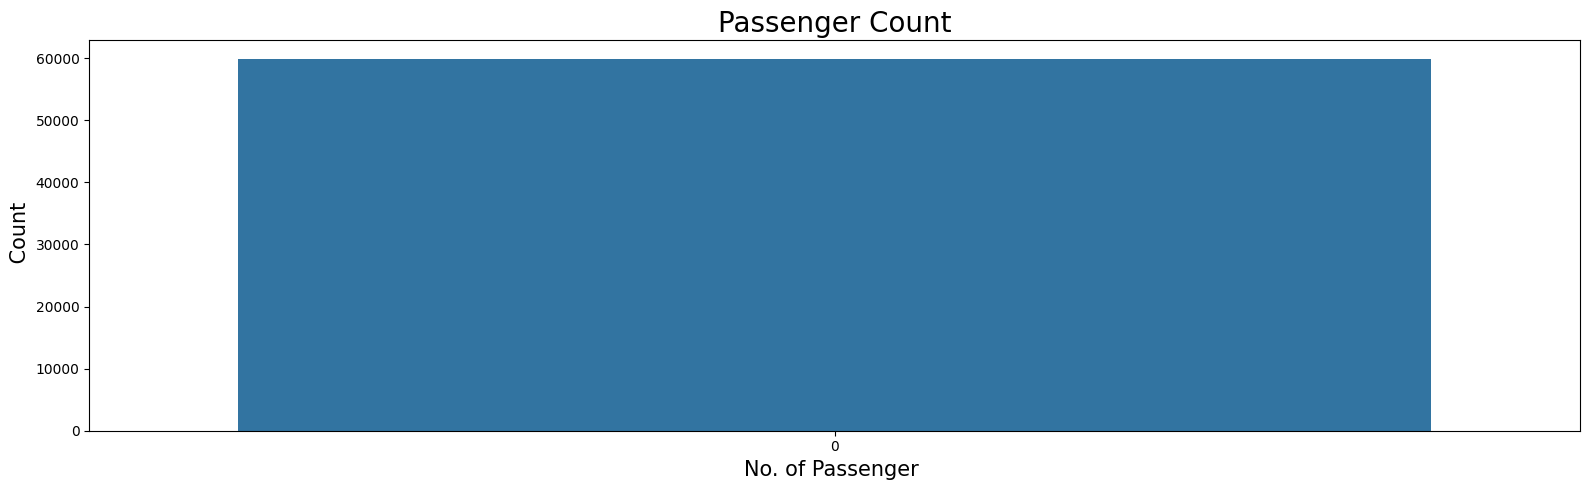

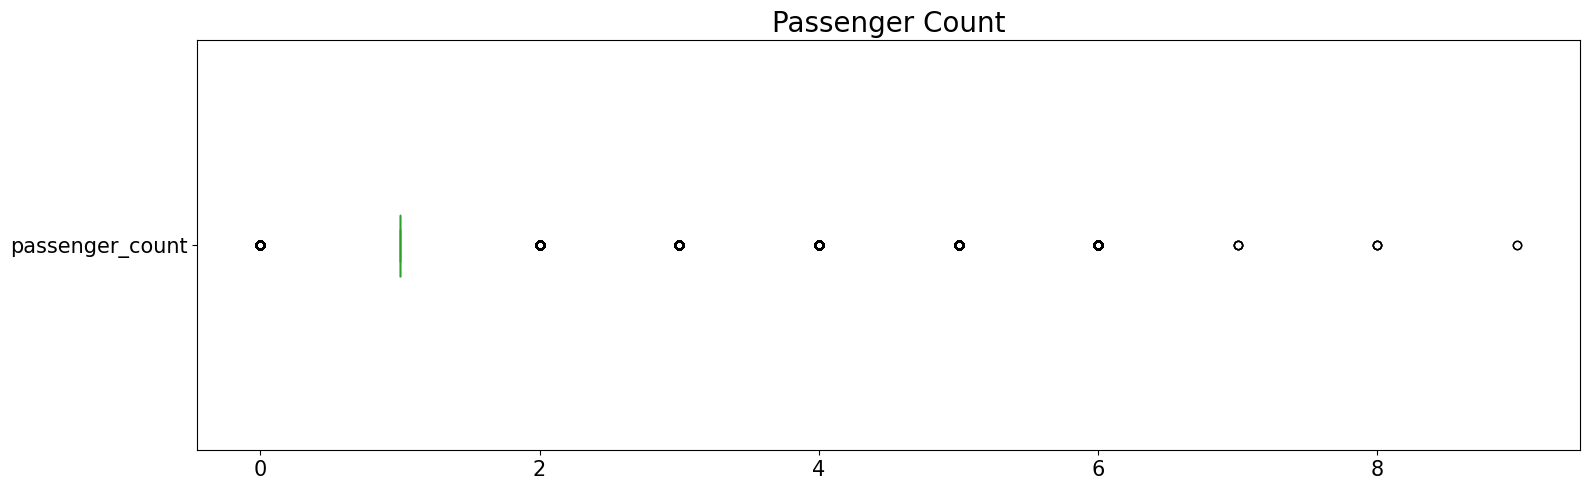

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,5))
# line = df['passenger_count'].value_counts().plot(kind='bar',fontsize = 15)
line = sns.countplot(green_tripdata.passenger_count.astype(int))
line.set_ylabel(" Count",fontsize = 15)
line.set_xlabel("No. of Passenger ",fontsize = 15)
line.set_title('Passenger Count',fontsize = 20)
fig.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,5))
box = green_tripdata['passenger_count'].plot(kind='box',vert = False,fontsize = 15)
box.set_title('Passenger Count',fontsize = 20)
fig.tight_layout()

In [52]:
green_tripdata.trip_duration

0        401.00
1        772.00
2       1267.00
3        603.00
4       2245.00
          ...  
60753    669.00
60754    243.00
60755    455.00
60756    350.00
60757    605.00
Name: trip_duration, Length: 59873, dtype: float64

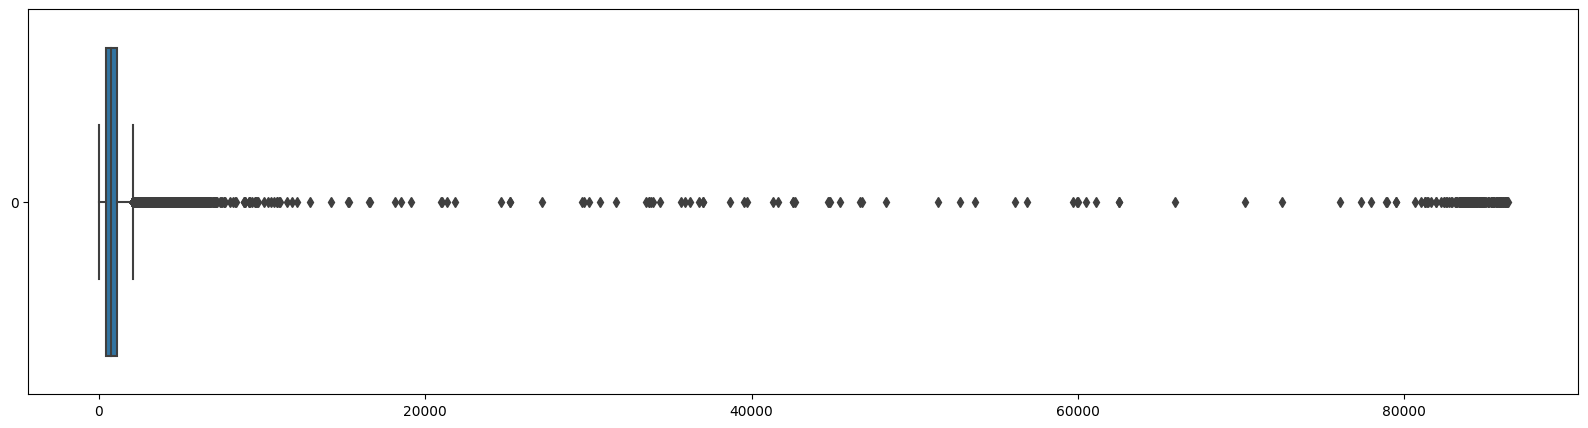

In [56]:
plt.figure(figsize = (20,5))
sns.boxplot(green_tripdata.trip_duration, orient="h")
plt.show()

1. Some trip durations are over 100000 seconds which are clear outliers and should be removed.
2. There are some durations with as low as 1 second. which points towards trips with 0 km distance.
3. Major trip durations took between 10-20 mins to complete.
4. Mean and mode are not same which shows that trip duration distribution is skewed towards right

In [57]:
green_tripdata.trip_duration.groupby(
    pd.cut(
        green_tripdata.trip_duration, np.arange(1,max(green_tripdata.trip_duration),3600)
        )
    ).count()

/tmp/ipykernel_84066/629412021.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  green_tripdata.trip_duration.groupby(


trip_duration
(1.0, 3601.0]         59030
(3601.0, 7201.0]        557
(7201.0, 10801.0]        28
(10801.0, 14401.0]        9
(14401.0, 18001.0]        4
(18001.0, 21601.0]        6
(21601.0, 25201.0]        3
(25201.0, 28801.0]        2
(28801.0, 32401.0]        5
(32401.0, 36001.0]        8
(36001.0, 39601.0]        6
(39601.0, 43201.0]        6
(43201.0, 46801.0]        6
(46801.0, 50401.0]        1
(50401.0, 54001.0]        3
(54001.0, 57601.0]        2
(57601.0, 61201.0]        5
(61201.0, 64801.0]        2
(64801.0, 68401.0]        1
(68401.0, 72001.0]        1
(72001.0, 75601.0]        1
(75601.0, 79201.0]        5
(79201.0, 82801.0]       18
Name: trip_duration, dtype: int64

* These trips ran for more than 20 days, which seems unlikely by the distance travelled.
* All the trips are taken by vendor 1 which points us to the fact that this vendor might allows much longer trip for outstations.
* All these trips are either taken on Tuesday's in 1st month or Saturday's in 2nd month. There might be some relation with the weekday, pickup location, month and the passenger.
* But they fail our purpose of correct prediction and bring inconsistencies in the algorithm calculation.

/tmp/ipykernel_84066/2319581335.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  green_tripdata.trip_duration.groupby(pd.cut(green_tripdata.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh',figsize = (18,5))


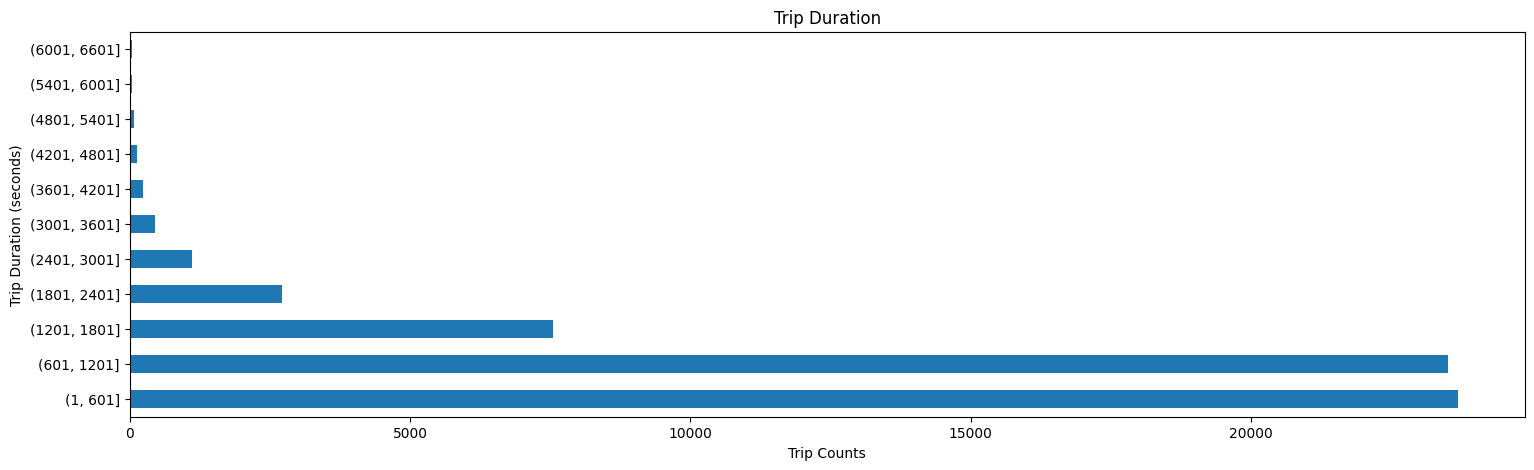

In [58]:
green_tripdata.trip_duration.groupby(pd.cut(green_tripdata.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh',figsize = (18,5))
plt.title('Trip Duration')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs.

### Distance

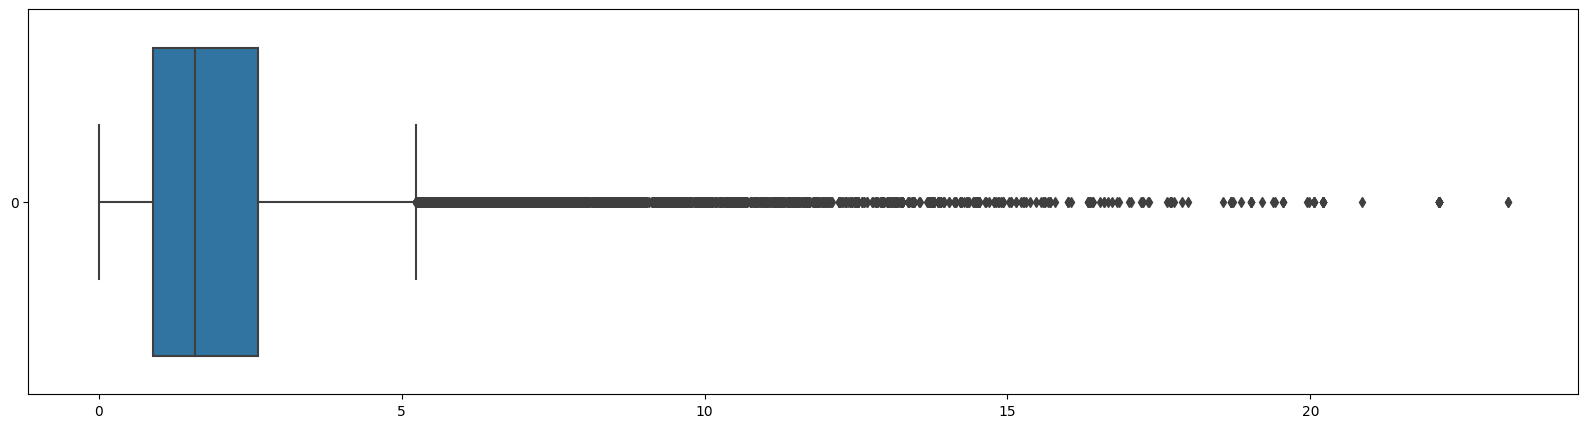

In [60]:
plt.figure(figsize = (20,5))
sns.boxplot(green_tripdata.distance, orient="h")
plt.show()

Interesting find:
* There some trips with over 60 miles distance.
* Some of the trips distance value is 0 miles.
Observations:
* mean distance travelled is approx 2.1 miles.

In [61]:
print(f"There are {green_tripdata.distance[green_tripdata.distance == 0 ].count()} trip records with 0 miles distance")

There are 6911 trip records with 0 miles distance


There are 5897 trip records with 0 miles distance
* Around 6K trip record with distance equal to 0. Below are some possible explanation for such records.
1. Customer changed mind and cancelled the journey just after accepting it.
2. Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location.
3. Issue with GPS tracker while the journey is being finished.
4. Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
5. Or some other issue with the software itself which a technical guy can explain
There is some serious inconsistencies in the data where drop off location is same as the pickup location. We can't think off imputing the distance values considering a correlation with the duration because the dropoff_location coordinates would not be inline with the distance otherwise. We will look more to it in bivariate analysis with the Trip duration.

/tmp/ipykernel_84066/756543888.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  green_tripdata.distance.groupby(pd.cut(green_tripdata.distance, np.arange(0,80,10))).count().plot(kind='barh',figsize = (19,4))


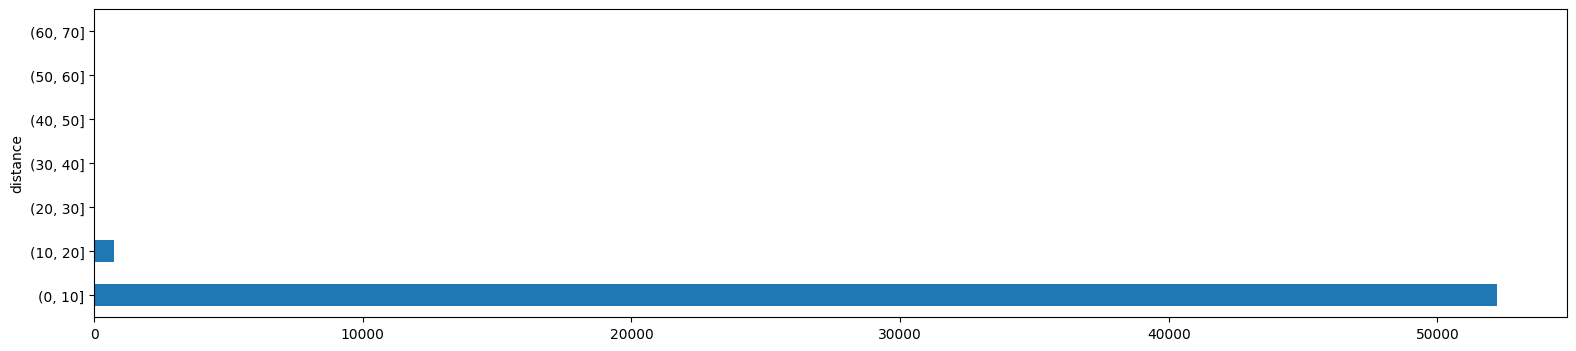

In [62]:
green_tripdata.distance.groupby(pd.cut(green_tripdata.distance, np.arange(0,80,10))).count().plot(kind='barh',figsize = (19,4))
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 miles with some of the rides with distances between 10-30 miles. Other slabs bar are not visible because the number of trips are very less as compared to these slabs

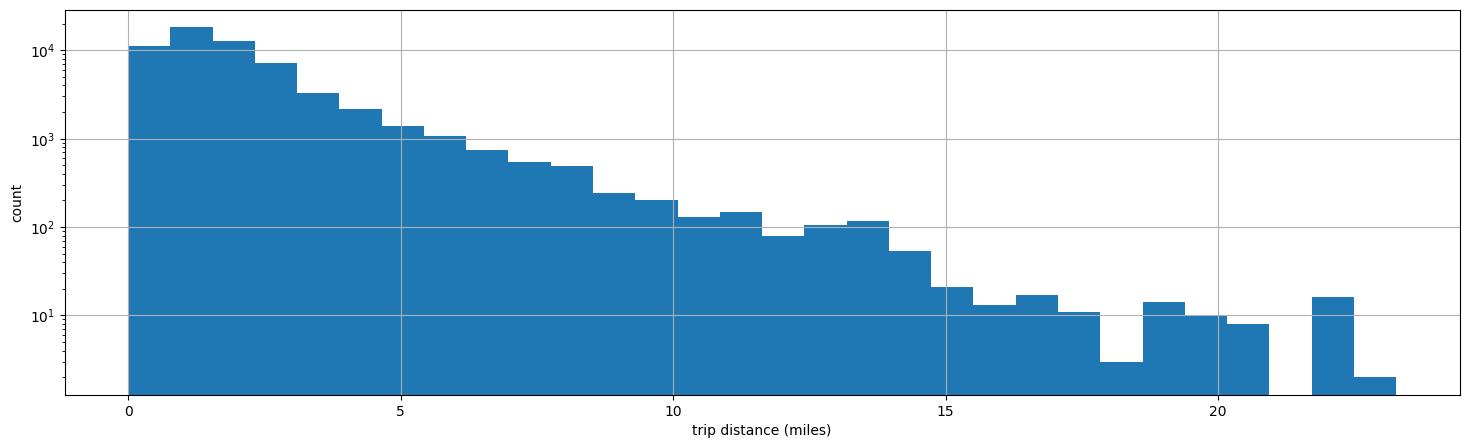

In [63]:
ax = green_tripdata['distance'].hist(bins=30, figsize=(18,5))
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

According to the dustribution of trip distances and the fact that it takes about 30 miles to drive across the whole New York City, we decided to use 30 as the number to split the trips into short or long distance trips.

In [65]:
df_short = green_tripdata[green_tripdata.distance <= 30].count()
df_long = green_tripdata[green_tripdata.distance > 30].count()
print(f"Short Trips: {df_short[0]} records in total.\nLong Trips: {df_long[0]} records in total.")

Short Trips: 59873 records in total.
Long Trips: 0 records in total.


/tmp/ipykernel_84066/3500854610.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Short Trips: {df_short[0]} records in total.\nLong Trips: {df_long[0]} records in total.")


Short Trips: 1458545 records in total.
Long Trips: 99 records in total.

Speed is a function of distance and time. Let's visualize speed in different trips.

Maximum speed limit in NYC is as follows:

* 25 mph in urban area
* 65 mph on controlled state highways

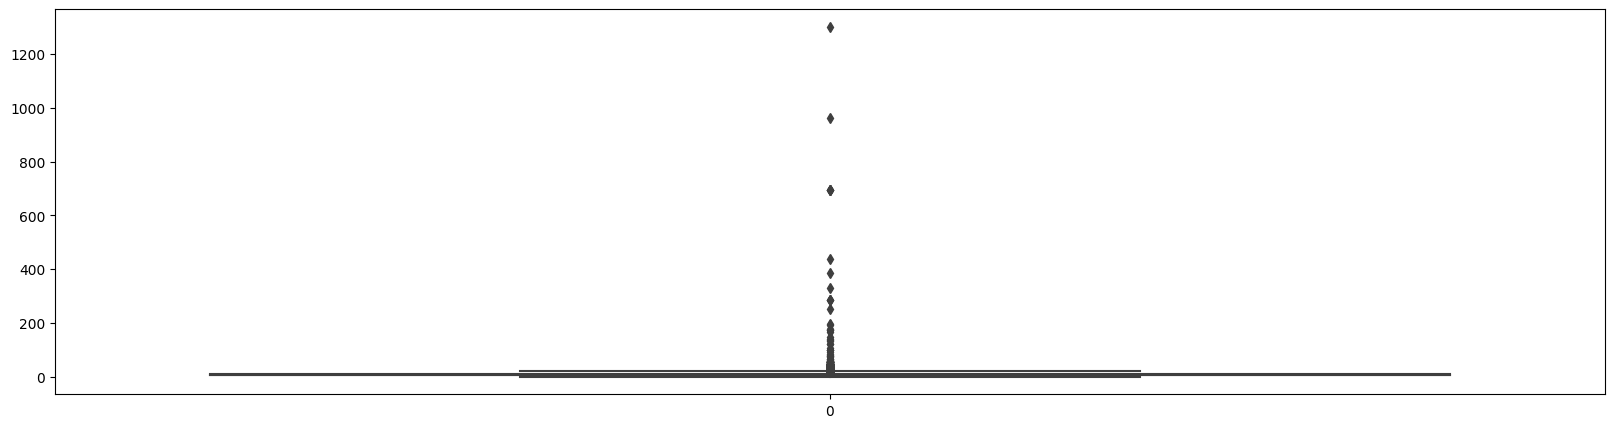

In [66]:
plt.figure(figsize = (20,5))
sns.boxplot(green_tripdata.speed)
plt.show()

* Many trips were done at a speed of over 125 mile/h. Going SuperSonic..!!
=> Let's remove them and focus on the trips which were done at less than 65 mile/h as per the speed limits

/tmp/ipykernel_84066/1230390331.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.speed.groupby(pd.cut(df.speed, np.arange(0,65,10))).count().plot(kind = 'barh',figsize = (19,5))


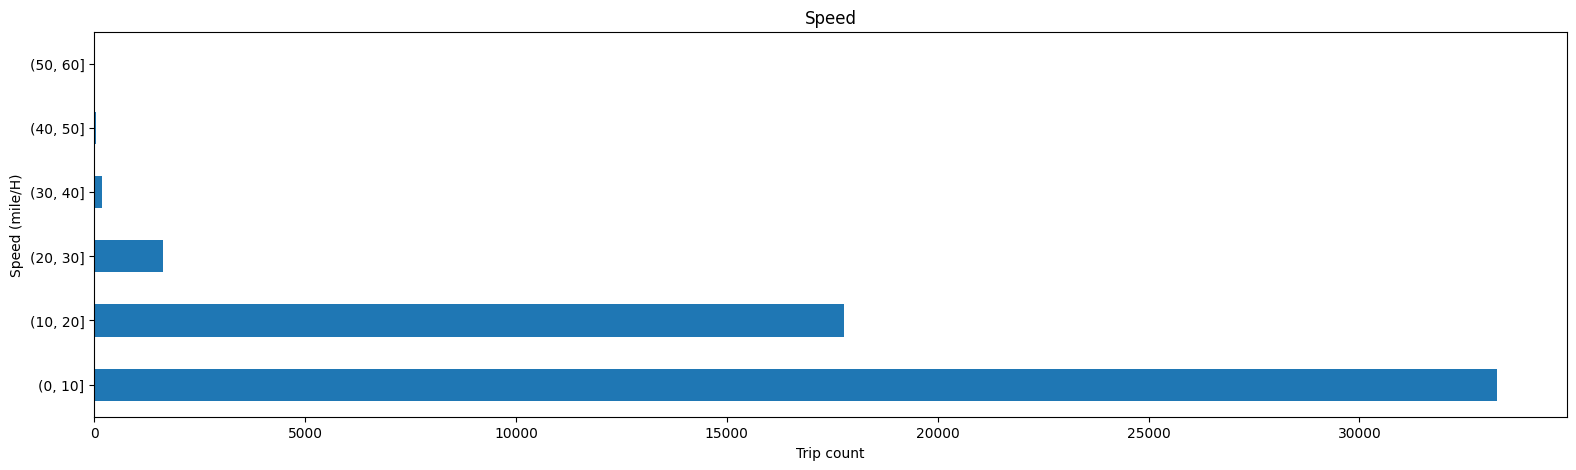

In [67]:
df = green_tripdata[green_tripdata.speed <= 65]
df.speed.groupby(pd.cut(df.speed, np.arange(0,65,10))).count().plot(kind = 'barh',figsize = (19,5))
plt.xlabel('Trip count')
plt.ylabel('Speed (mile/H)')
plt.title('Speed')
plt.show()

/tmp/ipykernel_84066/1230390331.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.speed.groupby(pd.cut(df.speed, np.arange(0,65,10))).count().plot(kind = 'barh',figsize = (19,5))


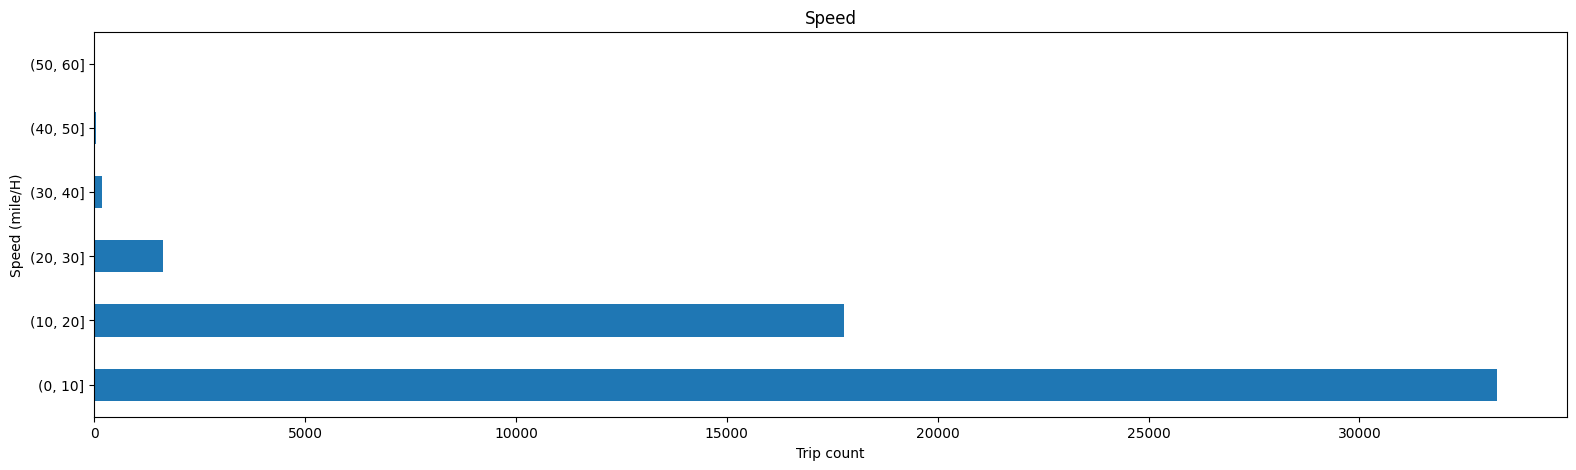

In [68]:
df = green_tripdata[green_tripdata.speed <= 65]
df.speed.groupby(pd.cut(df.speed, np.arange(0,65,10))).count().plot(kind = 'barh',figsize = (19,5))
plt.xlabel('Trip count')
plt.ylabel('Speed (mile/H)')
plt.title('Speed')
plt.show()

* Trips over 15 miles/h are being considered as outliers but we cannot ignore them because they are well under the highest speed limit of 65 mile/h on state controlled highways.
* Mostly trips are done at a speed range of 6-12 miles/h with an average speed of around 8 miles/h.
=> It is evident from this graph what we thought off i.e. most of the trips were done at a speed range of 6-12 miles/H.

In [69]:
def clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

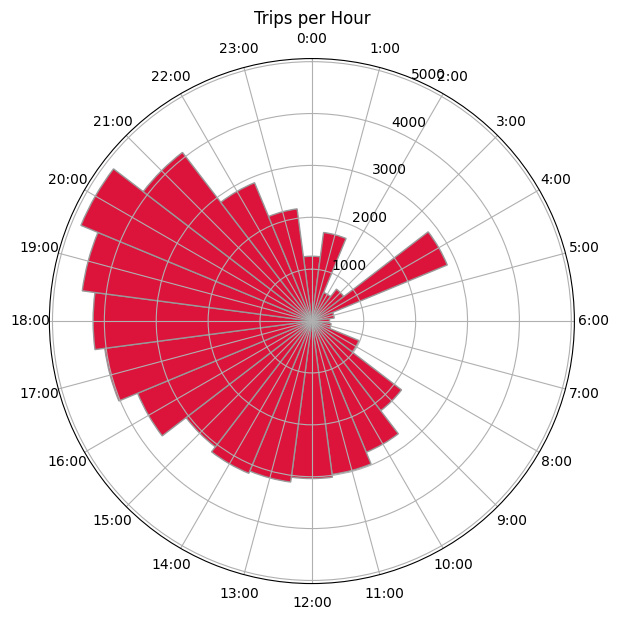

In [73]:
plt.figure(figsize = (15,15))
ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
radii = np.array(green_tripdata['pickup_hour'].value_counts(sort = False).tolist(), dtype="int64")
# radii = np.array(df['pickup_hour'].value_counts().tolist(), dtype="int64")
title = "Trips per Hour"
clock(ax, radii, title, "#dc143c")

* It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.
* The number of pickup is maximum at 6-7 pm.

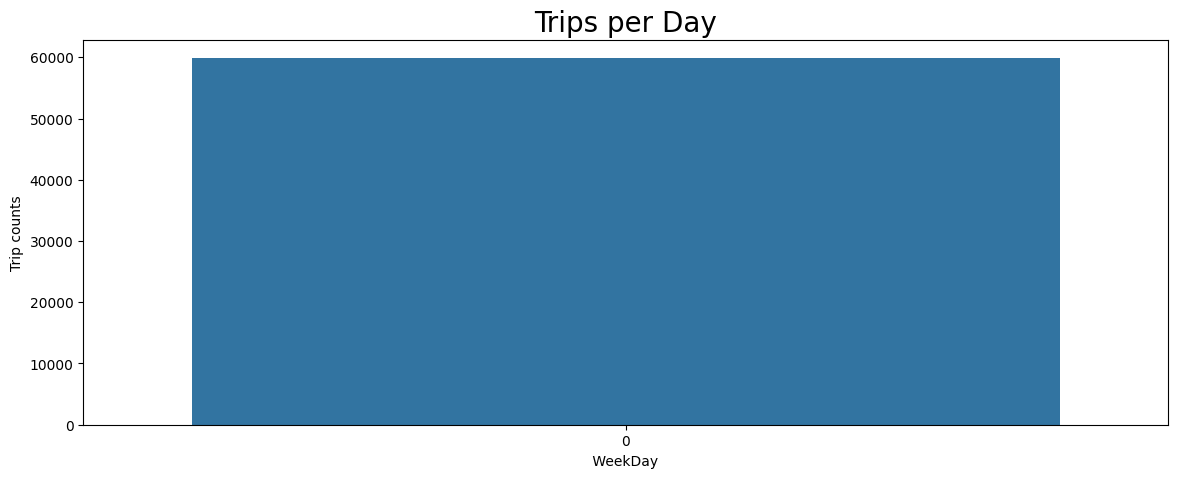

In [74]:
plt.figure(figsize = (14,5))
sns.countplot(green_tripdata.weekday_num)
plt.xlabel(' WeekDay ')
plt.ylabel('Trip counts')
plt.title('Trips per Day',fontsize = 20)
plt.show()

* Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

Let's drill down more to see the hourwise pickup pattern across the week

/home/hungnq/anaconda3/envs/torch/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hungnq/anaconda3/envs/torch/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


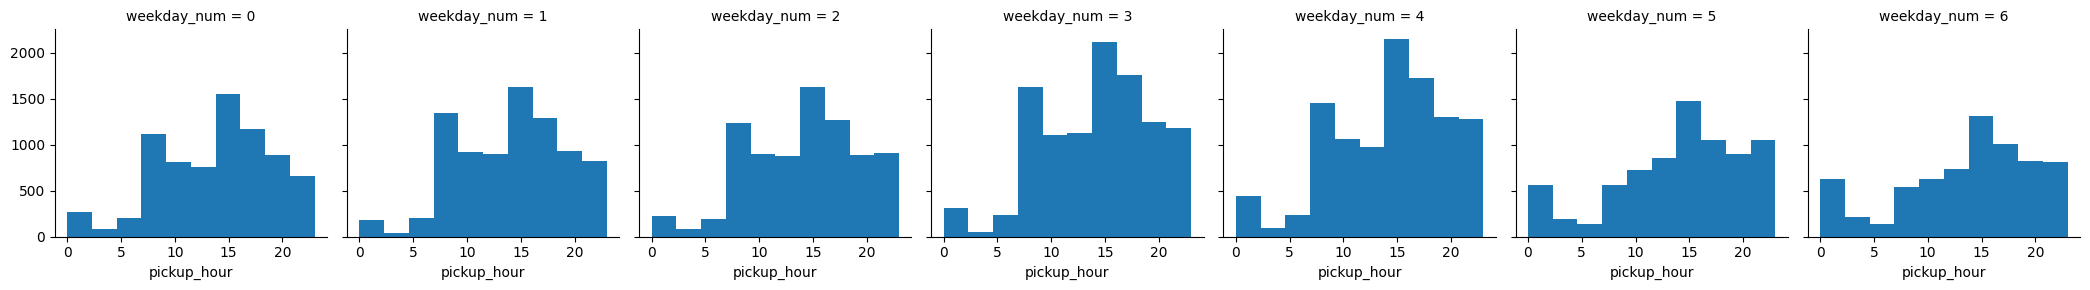

In [75]:
n = sns.FacetGrid(df, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

* Taxi pickups increased in the late night hours over the weekend possibly due to more outstation rides or for the late night leisures nearby activities.
* Early morning pickups i.e before 5 AM have increased over the weekend in comparison to the office hours pickups i.e. after 7 AM which have decreased due to obvious reasons.
* Taxi pickups seems to be consistent across the week at 15 Hours i.e. at 3 PM.

Let's take a look at the trip distribution across the months to understand if there is any diffrence in the taxi pickups in different months


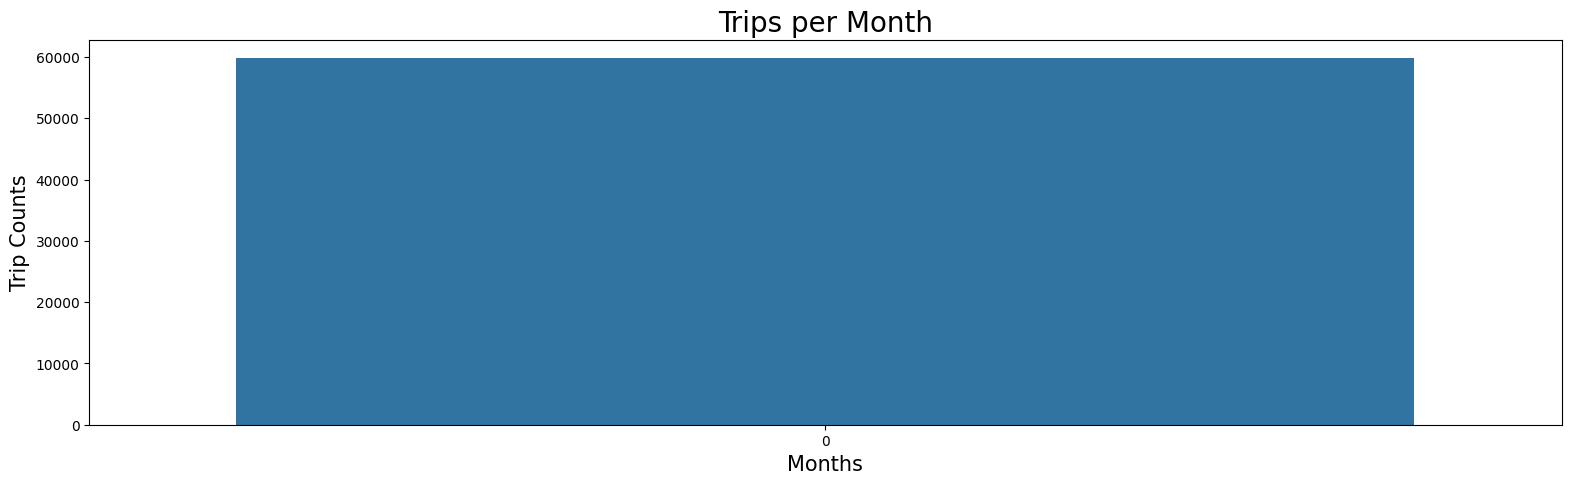

In [76]:
plt.figure(figsize = (19,5))
sns.countplot(df.month)
plt.ylabel('Trip Counts',fontsize = 15)
plt.xlabel('Months',fontsize = 15)
plt.title('Trips per Month',fontsize = 20)
plt.show()

Quite a balance across the months here. It could have been more equivalent if we wouldn't have removed the inconsistent records in our study of the univariate analysis

## Bivariate Analysis

###  1.Trip Duration per hour
We need to aggregate the total trip duration to plot it agaist the month. The aggregation measure can be anything like sum, mean, median or mode for the duration. Since we already did the outlier analysis, so we can take the mean to visualize the pattern which should not result in the bias of the general trend.

Lets take a look.

In [ ]:
plt.figure(figsize = (14,5))
group1 = df.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.title('Trip Duration per Hour')
plt.show()

* Average trip duration is lowest at 6 AM when there is minimal traffic on the roads.
* Average trip duration is generally highest around 3 PM during the busy streets.
* Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM.

### 2.Trip duration per WeekDay
Let's now analyze the pattern of trip duration during the week.

In [ ]:
plt.figure(figsize = (14,5))
group2 = df.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.title('Trip Duration per WeekDay')
plt.show()

We can see that trip duration is almost equally distributed across the week on a scale of 0-1000 minutes with minimal difference in the duration times. Also, it is observed that trip duration on thursday is longest among all days.

### 3.Trip duration per Month
Let's take a look at the trip duration pattern with respect to the different months.

In [ ]:
plt.figure(figsize = (14,5))
group3 = df.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.title('Trip Duration per Month')
plt.show()

* We can see an increasing trend in the average trip duration along with each subsequent month.
* The duration difference between each month is not much. It has increased gradually over a period of 6 months.
* It is lowest during february when winters starts declining.
* There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. Like May is generally the considered as the wettest month in NYC and which is inline with our visualization. As it generally takes longer on the roads due to traffic jams during rainy season. So natually the trip duration would increase towards April May and June.

### 4.Trip duration per vendor
We can also look at the average difference between the trip duration for each vendor. However we do know that vendor 2 has larger share of the market. Let's visualize.

In [ ]:
group4 = df.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.title('Trip Duration per Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by a quite low margin.

### 5.Distance per hour
Now, let us check how the distance is distributed against different variables. We know that trip distance must be more or less proportional to the trip duration if we ignore general traffic and other stuff on the road. Let's visualize this for each hour now.

Since we have already done the outlier analysis for this variable as well. We can take the mean as aggregate measure for our visualizations.

In [ ]:
plt.figure(figsize = (14,5))
group5 = df.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (mile)')
plt.title('Distance per Hour')
plt.show()

* Trip distance is highest during early morning hours which can account for some things like:
    1. Outstation trips taken during the weekends.
    2. Longer trips towards the city airport which is located in the outskirts of the city.
* Trip distance is fairly equal from morning till the evening varying around 2 - 2.5 mile.
* It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.

### 6.Distance per WeekDay
Let's analyze the average trip distance covered on each day of the week.

In [ ]:
plt.figure(figsize = (14,5))
group6 = df.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (mile)')
plt.title('Distance per WeekDay')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 2 mile/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

### 7.Distance per Month
Now we will look at the average trip distance covered per month.

In [ ]:
plt.figure(figsize = (14,5))
group7 = df.groupby('month').distance.mean()
sns.pointplot(group7.index, group7.values)
plt.ylabel('Distance (mile)')
plt.xlabel('Month')
plt.title('Distance per Month')
plt.show()

Here also the distibution is almost equivalent, varying mostly around 3.5 km/h with 5th month being the highest in the average distance and 2nd month being the lowest.

### 8.Distance per Vendor
Let's check how both the vendors have covered the average distance during the trips

In [ ]:
group8 = df.groupby('vendor_id').distance.mean()
sns.barplot(group8.index, group8.values)
plt.ylabel("Distance mile")
plt.xlabel("Vendor")
plt.title('Distance per Vendor')
plt.show()

This is more or less same picture with both the vendors. Nothing more to analyze in this.

### 9.Distance v/s Trip duration
Let's visualize the relationship between Distance covered and respective trip duration.

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(df.trip_duration, df.distance , s=5, alpha=1)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.title('Distance v/s Trip Duration')
plt.show()

* There are lots of trips which covered negligible distance but clocked more than 20,000 seconds in terms of the Duration.
* Initially there is some proper correlation between the distance covered and the trip duration in the graph. but later on it all seems uncorrelated.
* There were few trips which covered huge distance of approx 120 miles within very less time frame, which is unlikely and should be treated as outliers.
Let's focus on the graph area where distance is < 30 mile and duration is < 1000 seconds.

In [ ]:
plt.figure(figsize = (10,5))
dur_dist = df.loc[(df.distance < 30) & (df.trip_duration < 1000), ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.title('Distance v/s Trip Duration')
plt.show()

    * There should have been a linear relationship between the distance covered and trip duration on an average but we can see dense collection of the trips in the lower right corner which showcase many trips with the inconsistent readings.
We should remove those trips which covered 0 mile distance but clocked more than 1 minute to make our data more consistent for predictive model. Because if the trip was cancelled after booking, than that should not have taken more than a minute time. This is our assumption.

### 10.Average speed per hour
Let's look at the average speed of NYC Taxi per hour.

In [ ]:
plt.figure(figsize = (14,5))
group9 = df.groupby('pickup_hour').speed.mean()
sns.pointplot(group9.index, group9.values)
plt.xlabel('Pick Up Hours')
plt.ylabel('Speed mile/h')
plt.title('Average Speed per Hour')
plt.show()

* The average trend is totally inline with the normal circumstances.
* Average speed tend to increase after late evening and continues to increase gradually till the late early morning hours.
* Average taxi speed is highest at 5 AM in the morning, then it declines steeply as the office hours approaches.
* Average taxi speed is more or less same during the office hours i.e. from 8 AM till 6PM in the evening.

### 11.Average speed per weekday
Let's visualize that on an average what is the speed of a taxi on any given weekday.

In [ ]:
plt.figure(figsize = (14,5))
group10 = df.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.xlabel('Pick Up WeekDay')
plt.ylabel('Speed mile/h')
plt.title('Average Speed per WeekDay')
plt.show()

* Average taxi speed is higher on weekend as compared to the weekdays which is obvious when there is mostly rush of office goers and business owners.
* Even on monday the average taxi speed is shown higher which is quite surprising when it is one of the most busiest day after the weekend. There can be several possibility for such behaviour
* Lot of customers who come back from outstation in early hours of Monday before 6 AM to attend office on time.
    1. Early morning hours customers who come from the airports after vacation to attend office/business on time for the coming week.
    2. There could be some more reasons as well which only a local must be aware of.
* We also can't deny the anomalies in the dataset. which is quite cumbersome to spot in such a large dataset.

### 12.Passenger count per vendor
Let's try some different metric in the series i.e. passenger count. We will plot it agaist the vendor only because it will not be much helpful to plot it against hour, weekday or month like others as the passenger count should be a whole number and not a ratio.

we will take mean as the aggregate measure because we already did the outlier analysis on this metric. So our results woudn't be affected by some extreme values. Also if we take median than it will return only 1 because majorty of the trips have been taken by single passenger. Let's take a look about it's distribution.

In [ ]:
group9 = df.groupby('vendor_id').passenger_count.mean()
sns.barplot(group9.index, group9.values)
plt.ylabel('Passenger count')
plt.xlabel('Vendor Id')
plt.title('Passenger Count per Vendor')
plt.show()

Clear difference between the two operators for the average passenger count in all trips. It seems that vendor 2 trips generally consist of 2 passengers as compared to the vendor 1 with 1 passenger. Let's bifurcate it further.

    * It seems that most of the big cars are served by the Vendor 2 including minivans because other than passenger 1, vendor 2 has majority in serving more than 1 passenger count and that explains it greater share of the market.

## Feature Engineering

### 1. Feature Selection

In [ ]:
df.dtypes

* id column has unique values which means its no use to take id in model training
* Columns such as pickup_datetime,dropoff_datetime has object dtype and the values are datetype which may not able to evaluate by model which can affect in accuracy.
* Therefore pickup_datetime is been converted into weekday, month, weekday_num, pickup_hour, pickup_longitude,pickup_latitude and dropoff_longitude,dropoff_latitude are the columns which are dependent on each other.
* This columns does not mean much if pass as individual columns.
* Other than this store_and_fwd_flag is just a service info column.
* Excluding this columns the other columns such as vendor_id, passenger_count, distance, speed correlate with duration which can be used in model train.

In [ ]:
df.shape

In [ ]:
x = df.iloc[:, [1, 4, 11, 12, 14, 15, 16, 17, 18]].values
y = df.iloc[:,10].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 7294)

In [ ]:
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((x_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:9].columns.tolist()
target = df1.iloc[:,9].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

Column 7 and 8 shows negative correlation which means its not useful in model training. It can leave reverse impact on model

### 2.Feature Extraction
#####  Split Data

In [ ]:
x = df.iloc[:, [1, 4, 11, 12, 14, 15, 16]].values
y = df.iloc[:,10].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 7294)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

In [ ]:
Here we can see that 6 variables are sufficient for capturing atleast 99% of the variance in the training dataset. Hence we will use the same set of variables(i.e this model does not require the use of PCA).

### 3.Correlation Analysis
Correlation analysis is a method of statistical evaluation used to study the strength of a relationship between two or more, numerically measured, continuous variables. This analysis is useful when we need to check if there are possible connections between variables. We will utilize Heatmap for our analysis.


#### Heatmap
A heatmap is a graphical representation of data that uses a system of color-coding to represent statistical relationship between different values.

In [ ]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(x_train[:,0:]).corr()
corr.index = pd.DataFrame(x_train[:,0:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

* Some combinations of features shows slight correlation.
* But most of the features shows no correlation
* There is no negative correlation

## Model
We need a model to train on our dataset to serve our purpose of prediciting the NYC taxi trip duration given the other features as training and test set. Since our dependent variable contains continous values so we will use regression technique to predict our output. We will try almost every Regression model (except SVR)

### 1.Multiple Linear Regression

In [ ]:
start_time = time.time()
lm_regression = LinearRegression()
lm_regression = lm_regression.fit(x_train, y_train)
end_time = time.time()
lm_time = (end_time - start_time)
print(f"Time taken to train linear regression model : {lm_time} seconds")

In [ ]:
trips = lm_regression.predict(x_test)

In [ ]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': trips.flatten()})
predictions

Accuracy Metrics

In [ ]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

From the above graph, we can see that there is quite difference between predicted values and Actual values
Lets check the r2_score value

In [ ]:
lm_score = r2_score(y_test, trips)
print(lm_score)

The r2_score is above 0.5 which is a good thing but it is quite low for a regression model.
Let's Move towards next Model

### 2.Decision Tree
Decision tree is one of the predictive modeling approaches used in statistics, data mining and machine learning. It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves)

In [ ]:
start_time = time.time()
dt_regression = DecisionTreeRegressor()
dt_regression = dt_regression.fit(x_train, y_train)
end_time = time.time()
dt_time = (end_time - start_time)
print(f"Time taken to train Decision tree model : {dt_time} seconds")

In [ ]:
trips = dt_regression.predict(x_test)

In [ ]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': trips.flatten()})
predictions

Accuracy Metrics

In [ ]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
    * From the above graph, we can see that difference is quite low between predicted values and Actual values
Lets check the r2_score value

In [ ]:
dt_score = r2_score(y_test, trips)
print(dt_score)

    * The r2 score is best but the time taken for execution is high
So, Let's check if we can get same accuracy with less execution time in next model.

### 3.Random Forest
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In [ ]:
start_time = time.time()
rf_regression = RandomForestRegressor()
rf_regression = rf_regression.fit(x_train, y_train)
end_time = time.time()
rf_time = (end_time - start_time)
print(f"Time taken to train Random Forest model : {rf_time} seconds")

In [ ]:
trips = rf_regression.predict(x_test)

In [ ]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': trips.flatten()})
predictions

Accuracy Metrics

In [ ]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
rf_score = r2_score(y_test, trips)
print(rf_score)

### XGBoost
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework

In [ ]:
start_time = time.time()
regression = XGBRegressor(objective ='reg:squarederror')
regression = regression.fit(x_train, y_train)
end_time = time.time()
xgb_time = (end_time - start_time)
print(f"Time taken to train XGBoost  model : {xgb_time} seconds")

In [ ]:
trips = regression.predict(x_test)

In [ ]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': trips.flatten()})
predictions

Accuracy Metrics

In [ ]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
xgb_score = r2_score(y_test, trips)
print(xgb_score)

### Model Comparison

In [ ]:
r2 = [lm_score, dt_score, rf_score, xgb_score]
tm = [lm_time, dt_time, rf_time, xgb_time]
comp = pd.DataFrame({'Time': tm, 'Accu': r2})

In [ ]:
label = ['LM', 'DT', 'RF', 'XGB']
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = comp['Time'].plot(kind='bar',title="Time",ax=axes[0],color = (1, 0.5, 0.13))
ax1 = comp['Accu'].plot(kind='bar',title="Accuarcy",ax=axes[1])
ax.set_ylabel("Time (secs)")
ax.set_xlabel('Models')
ax.set_xticklabels(label)
ax1.set_ylabel("Accuracy")
ax1.set_xlabel('Models')
ax1.set_xticklabels(label)
fig.tight_layout()

From the above fig we can finally decide which Model is best suitable for this dataset.

* We should straight away reject Random Forest as it takes the most amount of time.
* Linear Regression takes Least amount of time but doesn't give much accuracy. 
* Which leaves with Decision Tree, and XGBoost.
* All of three have almost same Accuracy but Decision Tree takes least amount of time.